Adding information from
http://www.fao.org/soils-portal/data-hub/soil-maps-and-databases/harmonized-world-soil-database-v12/en/

In [68]:
%%capture
import vaex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import calendar
import multiprocessing
import json
import copy
import h5py
import seaborn as sns
%load_ext line_profiler

In [99]:
from scipy.sparse import dok_matrix
from tqdm.auto import tqdm

def make_sparse(path, dtype='int'):
    with open(path, "r") as file:
        cols, rows = int(file.readline().split()[1]), int(file.readline().split()[1])
        x_corner, y_corner = int(file.readline().split()[1]), int(file.readline().split()[1])
        cellsize = float(file.readline().split()[1])
        nodata_val = file.readline().split()[1]
        line = file.readline()
        if dtype == 'int':
            M = dok_matrix((rows, cols), dtype=np.int)
        if dtype == 'float':
            M = dok_matrix((rows, cols), dtype=np.float)
        empty_line = ' ' + ' '.join([nodata_val] * cols) + '\n'
        for i in tqdm(range(rows)):
            if empty_line != line:
                for j, val in enumerate(line.split()):
                    if val != nodata_val:
                        if dtype == 'int':
                            M[i,j] = int(val)
                        if dtype == 'float':
                            M[i,j] = float(val)
            line = file.readline()
        return M, x_corner, y_corner, cellsize

In [3]:
def sparse2dict(M, x_corner, y_corner, cellsize, name):
    sparse_dict = {
        'lon': [],
        'lat': [],
        name: [],
    }

    for i in tqdm(M.items()):
        lat, lon  = i[0]
        lon, lat = (x_corner + lon*cellsize), (abs(y_corner) - lat*cellsize)
        sparse_dict['lon'].append(lon)
        sparse_dict['lat'].append(lat)
        sparse_dict[name].append(i[1])
    return sparse_dict

In [4]:
M, x_corner, y_corner, cellsize = make_sparse("data/GloElev_5min.asc")
elev_dict = sparse2dict(M, x_corner, y_corner, cellsize, 'elevation')

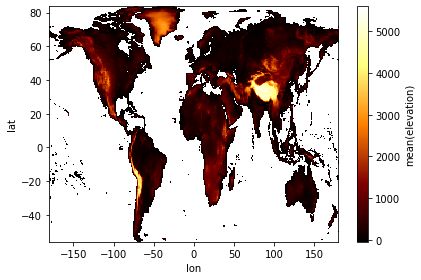

In [70]:
elev_df = vaex.from_dict(elev_dict)
elev_df.plot(elev_df.lon, elev_df.lat, what=vaex.stat.mean(elev_df.elevation));

In [48]:
drought_df = pd.read_pickle('drought_df.pkl').drop_duplicates(subset=['fips'])
drought_df = drought_df.drop(columns=['None','D0','D1','D2','D3','D4','date'])

In [49]:
def lonlat2xy(lon, lat, x_corner, y_corner, cellsize):
    return abs(int(round((lat + y_corner)/cellsize))), int(round((lon - x_corner)/cellsize))

In [50]:
def xy2lonlat(x, y, x_corner, y_corner, cellsize):
    return (x_corner + y*cellsize), (abs(y_corner) - x*cellsize)

In [51]:
lonlat2xy(80, -50, x_corner, y_corner, cellsize)

(1680, 3120)

In [52]:
xy_list = [lonlat2xy(row['lon'], row['lat'], x_corner, y_corner, cellsize) for _, row in tqdm(drought_df.iterrows(), total=len(drought_df))]

In [54]:
drought_df['arc_xy'] = xy_list

In [101]:
def add_value(drought_df, path, name, dtype='int'):
    M, x_corner, y_corner, cellsize = make_sparse(path, dtype)
    drought_df[name] = drought_df['arc_xy'].apply(lambda x: M[x])
    return drought_df

In [66]:
drought_df = add_value(drought_df, "data/GloElev_5min.asc", "elevation")

,fips,lat,lon,arc_xy,elevation
0,1001,32.536382,-86.644490,"(690, 1120)",63
0,1005,31.870670,-85.405456,"(698, 1135)",146
0,1003,30.659218,-87.746067,"(712, 1107)",52
0,1007,33.015893,-87.127148,"(684, 1114)",93
0,1009,33.977448,-86.567246,"(672, 1121)",198
...,...,...,...,...,...
0,56037,41.660339,-108.875676,"(580, 853)",2085
0,56039,44.049321,-110.588102,"(551, 833)",2564
0,56043,43.878831,-107.669052,"(553, 868)",1417
0,56041,41.284726,-110.558947,"(585, 833)",2327


<AxesSubplot:xlabel='lon', ylabel='lat'>

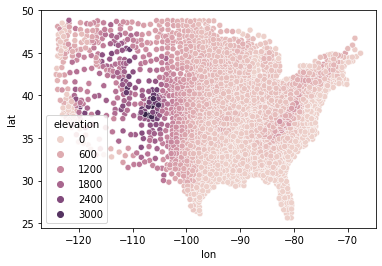

In [69]:
sns.scatterplot(data=drought_df, x='lon', y='lat', hue='elevation')

In [71]:
slopes = [
    ('data/GloSlopesCl1_5min.asc','slope1'),
    ('data/GloSlopesCl2_5min.asc','slope2'),
    ('data/GloSlopesCl3_5min.asc','slope3'),
    ('data/GloSlopesCl4_5min.asc','slope4'),
    ('data/GloSlopesCl5_5min.asc','slope5'),
    ('data/GloSlopesCl6_5min.asc','slope6'),
    ('data/GloSlopesCl7_5min.asc','slope7'),
    ('data/GloSlopesCl8_5min.asc','slope8'),
]

In [86]:
for path, slope in slopes:
    drought_df = add_value(drought_df, path, slope)
    drought_df[slope] = drought_df[slope]/10000

<AxesSubplot:xlabel='lon', ylabel='lat'>

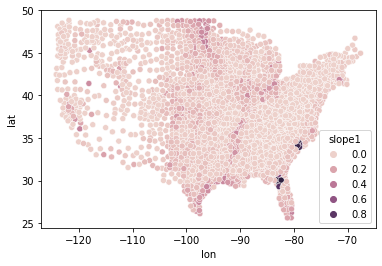

In [87]:
sns.scatterplot(data=drought_df, x='lon', y='lat', hue='slope1')

<AxesSubplot:xlabel='lon', ylabel='lat'>

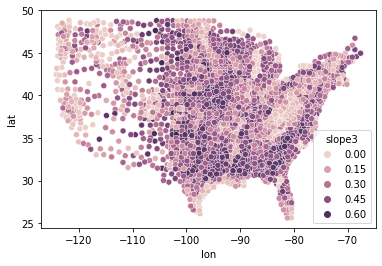

In [88]:
sns.scatterplot(data=drought_df, x='lon', y='lat', hue='slope3')

In [89]:
aspects = [
    ('data/GloAspectClN_5min.asc','aspectN'),
    ('data/GloAspectClE_5min.asc','aspectE'),
    ('data/GloAspectClS_5min.asc','aspectS'),
    ('data/GloAspectClW_5min.asc','aspectW'),
    ('data/GloAspectClU_5min.asc','aspectUnknown'),
]

In [90]:
for path, aspect in aspects:
    drought_df = add_value(drought_df, path, aspect)
    drought_df[aspect] = drought_df[aspect]/10000

<AxesSubplot:xlabel='lon', ylabel='lat'>

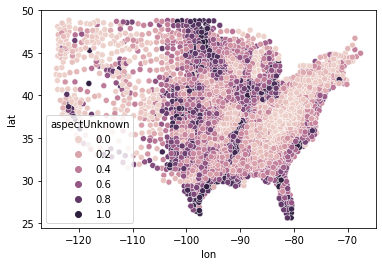

In [91]:
sns.scatterplot(data=drought_df, x='lon', y='lat', hue='aspectUnknown')

<AxesSubplot:xlabel='lon', ylabel='lat'>

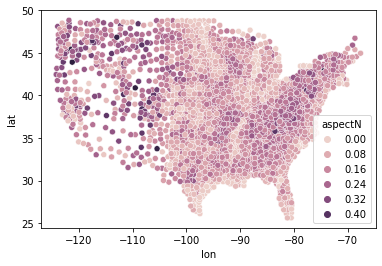

In [92]:
sns.scatterplot(data=drought_df, x='lon', y='lat', hue='aspectN')

In [93]:
land_covers = [
    'WAT', 'NVG', 'URB', 'GRS', 'FOR', 'CULTRF', 'CULTIR', 'CULT'
]

In [102]:
for land in land_covers:
    drought_df = add_value(drought_df, f'data/land_cover/{land}_2000.asc', f'{land}_LAND', dtype='float')
    drought_df[f'{land}_LAND'] = drought_df[f'{land}_LAND']

In [113]:
sqs = list(range(1,8))

In [114]:
for sq in sqs:
    drought_df = add_value(drought_df, f'data/soil_quality/sq{sq}.asc', f'SQ{sq}', dtype='int')
    drought_df[f'SQ{sq}'] = drought_df[f'SQ{sq}']

<AxesSubplot:xlabel='lon', ylabel='lat'>

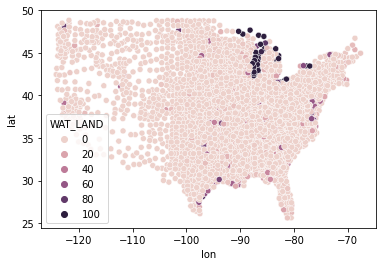

In [115]:
sns.scatterplot(data=drought_df, x='lon', y='lat', hue='WAT_LAND')

<AxesSubplot:xlabel='lon', ylabel='lat'>

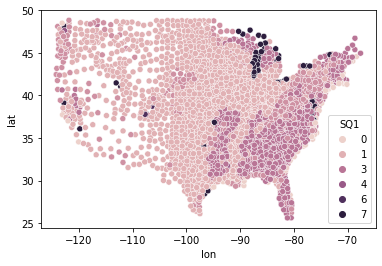

In [123]:
sns.scatterplot(data=drought_df, x='lon', y='lat', hue='SQ1')

In [134]:
drought_df = drought_df.drop(columns=['arc_xy'])

In [137]:
drought_df = drought_df.set_index('fips')

In [139]:
drought_df.to_csv('soil_data.csv')

In [140]:
drought_df_c = pd.read_csv('soil_data.csv')